In [64]:
import pandas as pd
from Bio import SeqIO
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import random

In [27]:
allseqs = list(SeqIO.parse('allseqs.fasta', 'fasta'))
print(len(allseqs))

410768


**Note: we're filtering out sequences that are too big now.**

In [28]:
allseqs = [s for s in allseqs if len(s) <= 1000]
allseqs_mapped = {s.id: s for s in allseqs}
print(len(allseqs))

379307


In [29]:
print(f"Total Pos: {sum([1 for s in allseqs if s.id[:3] == 'tox'])}")
print(f"Total Neg: {sum([1 for s in allseqs if s.id[:3] == 'non'])}")

Total Pos: 181080
Total Neg: 198227


There is now a slight imbalance: we have fewer positive samples than we have negative samples.
We will address this through sampling reductions, meaning our max number of sequences is now 362,160. Otherwise, we proceed by creating an all sequence mapping.

In [30]:
seqMasterKey = pd.read_csv('ClustDBTSV.tsv', sep='\t', header=None, names=['Cluster', 'SequenceId'])
seqMasterKey

,Cluster,SequenceId
0,nontox-omWr3L,nontox-omWr3L
1,nontox-omWr3L,nontox-U42kPM
2,nontox-omWr3L,nontox-rzBfU4
3,nontox-omWr3L,nontox-nnHGIb
4,nontox-omWr3L,nontox-PmUwlh
...,...,...
410763,nontox-euVuBJ,nontox-ofFbKS
410764,nontox-euVuBJ,nontox-UML8dE
410765,nontox-k9rFgy,nontox-k9rFgy
410766,nontox-34o3qH,nontox-34o3qH


In [31]:
clustered_seqs = {}
for index, row in seqMasterKey.iterrows():
    curr_clust = row['Cluster']
    if row['SequenceId'] not in allseqs_mapped:
        continue
    elif curr_clust in clustered_seqs:
        clustered_seqs[curr_clust] += [allseqs_mapped[row['SequenceId']]]
    else:
        clustered_seqs[curr_clust] = [allseqs_mapped[row['SequenceId']]]
print(len(clustered_seqs))

80157


In [32]:
len(seqMasterKey['Cluster'].unique())

88031

**Note: by excluding sequences greater than 1000 AA in length, we also eliminate about 8000 clusters. Most of these clusters however were very small clusters, and therefore there hasn't been too much change to the sets yet.**

In [33]:
cluster_sizes = [len(clustered_seqs[x]) for x in clustered_seqs]
avg_len = np.mean(cluster_sizes)
median_len = np.median(cluster_sizes)
print(avg_len)
print(median_len)

4.73205085020647
1.0


In [34]:
print(f'Total Clusters: {len(clustered_seqs)}')

Total Clusters: 80157


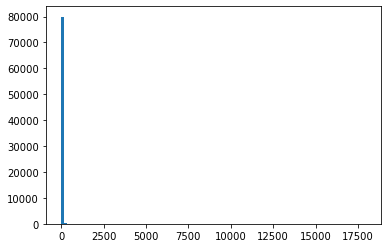

In [35]:
plt.figure()
plt.hist(cluster_sizes, bins=100)
plt.show()

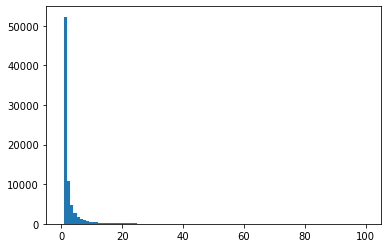

In [36]:
plt.figure()
plt.hist(cluster_sizes, bins=100, range=(0, 100))
plt.show()

In [37]:
clustersizes_np = np.array(cluster_sizes)

In [38]:
sum((clustersizes_np > 10) * 1.0)/len(clustersizes_np)

0.052434597103185

# Train Test Split Creation Algorithm

So, here's our goal: we want to make sure that clusters are segregated to either the train set or the test set. We also want to make sure that the proportion of toxin and nontoxins is the same too.

In [39]:
clustered_seqs_pos = {
    k: sum([1 for s in v if s.id[:3] == 'tox']) for k, v in clustered_seqs.items()
}
clustered_seqs_neg = {
    k: sum([1 for s in v if s.id[:3] == 'non']) for k, v in clustered_seqs.items()
}
clustered_seqs_total = {
    k: len(v) for k, v in clustered_seqs.items()
}

In [40]:
clustered_seqs_keys = list(clustered_seqs_total.keys())
clustered_seqs_counts = np.array(list(clustered_seqs_total.values()))
clustered_sort_indx = np.argsort(clustered_seqs_counts)[::-1]
clustered_seqs_keys_sorted = [clustered_seqs_keys[i] for i in clustered_sort_indx]
print(clustered_seqs_keys_sorted[:10])

['tox-bSbnW4', 'tox-gHiywl', 'tox-Oew6tZ', 'tox-rQqgdE', 'tox-kWWac6', 'tox-cDRLkx', 'tox-TR42cT', 'tox-JZb8Qu', 'tox-0wTQ70', 'tox-1p622z']


We also want to see how many "mismatches" there are. That is, we want to see the cases whether there are clusters that include both toxins and nontoxins together.

In [42]:
x = 0
mismatch_total = 0
mismatch_pos = 0
mismatch_neg = 0
for k in clustered_seqs_total:
    if clustered_seqs_pos[k] < clustered_seqs_total[k] and clustered_seqs_neg[k] < clustered_seqs_total[k]:
        x += 1
        mismatch_total += clustered_seqs_total[k]
        mismatch_pos += clustered_seqs_pos[k]
        mismatch_neg += clustered_seqs_neg[k]
print('Total clusters: ', len(clustered_seqs_total))
print('Total clusters with mismatches: ', x)
print('Total sequences in cluster w/ mismatches: ', mismatch_total)
print('Total pos sequences in cluster w/ mismatches: ', mismatch_pos)
print('Total neg sequences in cluster w/ mismatches: ', mismatch_neg)

Total clusters:  80157
Total clusters with mismatches:  1335
Total sequences in cluster w/ mismatches:  29374
Total pos sequences in cluster w/ mismatches:  21940
Total neg sequences in cluster w/ mismatches:  7434


# New split method.
#### So this is the updated attempt to get a better true split.

1. We begin by assigning all the all negative and all positive clusters, with the only goal of maintaining a 90%/10% train/test split. 
1. Next, we will look at the mismatch clusters.
    1. We will favor solutions that maintain a 50/50 split within the train set and within the test set.
    1. We will then downsample the train and test sets to be exactly 50/50 splits.
    1. We will then downsample the train and test sets to maintain the exact 90% to 10% ratio.
1. We will finally verify that we have both 90% train and 10% test, and 50% positive and 50% negative results inside each of these sets, writing out the results.

**First, negatives and positives split up.**

In [68]:
train_set = []
train_set_pos = 0
train_set_neg = 0

test_set = []
test_set_pos = 0
test_set_neg = 0

tr_ts_ratio = 0.9
pos_neg_ratio = 0.5

used_cluster_keys = set()

all_pos_cluster_keys = {k: clustered_seqs_total[k] for k in clustered_seqs_keys_sorted if clustered_seqs_total[k] == clustered_seqs_pos[k]}
print(f"Total All Pos Clusters: {len(all_pos_cluster_keys)}")
print(f"Total Seqs All Pos Clusters: {sum(all_pos_cluster_keys.values())}")

all_neg_cluster_keys = {k: clustered_seqs_total[k] for k in clustered_seqs_keys_sorted if clustered_seqs_total[k] == clustered_seqs_neg[k]}
print(f"Total All Neg Clusters: {len(all_neg_cluster_keys)}")
print(f"Total Seqs All Neg Clusters: {sum(all_neg_cluster_keys.values())}")

Total All Pos Clusters: 19639
Total Seqs All Pos Clusters: 159140
Total All Neg Clusters: 59183
Total Seqs All Neg Clusters: 190793


In [69]:
# Pos Cluster Keys
for k, v in all_pos_cluster_keys.items():
    curr_tr_ts_ratio = len(train_set)/(len(train_set) + len(test_set)) if len(train_set) != 0 else 0
    
    if curr_tr_ts_ratio < tr_ts_ratio:
        train_set += clustered_seqs[k]
        train_set_pos += v
    else:
        test_set += clustered_seqs[k]
        test_set_pos += v
    
    used_cluster_keys.add(k)

    
# Neg Cluster Keys
for k, v in all_neg_cluster_keys.items():
    curr_tr_ts_ratio = len(train_set)/(len(train_set) + len(test_set))
    
    if curr_tr_ts_ratio < tr_ts_ratio:
        train_set += clustered_seqs[k]
        train_set_neg += v
    else:
        test_set += clustered_seqs[k]
        test_set_neg += v
    
    used_cluster_keys.add(k)

print(f"Train Set Size: {len(train_set)}\nTrain Positives: {train_set_pos}\nTrain Negatives: {train_set_neg}\n\n")
print(f"Test Set Size: {len(test_set)}\nTest Positives: {test_set_pos}\nTest Negatives: {test_set_neg}\n\n")
print(f"Train / Test Proportion: {len(train_set)/(len(train_set) + len(test_set))}")
print(f"Train Percent Pos: {train_set_pos / len(train_set)}")
print(f"Test Percent Pos: {test_set_pos / len(test_set)}")

Train Set Size: 314939
Train Positives: 143226
Train Negatives: 171713


Test Set Size: 34994
Test Positives: 15914
Test Negatives: 19080


Train / Test Proportion: 0.8999979996170695
Train Percent Pos: 0.45477378158945064
Test Percent Pos: 0.45476367377264676


**Now, only the mismatched sets.**

In [70]:
all_mismatch_keys = {k: (clustered_seqs_pos[k], clustered_seqs_neg[k]) for k in clustered_seqs_keys_sorted if k not in used_cluster_keys}
print(f"Total Mismatch Keys: {len(all_mismatch_keys)}")
print(f"Total Pos Mismatch Seqs: {sum([x[0] for x in all_mismatch_keys.values()])}")
print(f"Total Neg Mismatch Seqs: {sum([x[1] for x in all_mismatch_keys.values()])}")

Total Mismatch Keys: 1335
Total Pos Mismatch Seqs: 21940
Total Neg Mismatch Seqs: 7434


In [71]:
for k, v in all_mismatch_keys.items():
    new_tr_rt = (train_set_pos + v[0]) / (len(train_set) + sum(v))
    new_ts_rt = (test_set_pos +v[0]) / (len(test_set) + sum(v))
        
    if abs(new_tr_rt - pos_neg_ratio) < abs(new_ts_rt - pos_neg_ratio):
        train_set += clustered_seqs[k]
        train_set_pos += v[0]
        train_set_neg += v[1]
    else:
        test_set += clustered_seqs[k]
        test_set_pos += v[0]
        test_set_neg += v[1]

print(f"Train Set Size: {len(train_set)}\nTrain Positives: {train_set_pos}\nTrain Negatives: {train_set_neg}\n\n")
print(f"Test Set Size: {len(test_set)}\nTest Positives: {test_set_pos}\nTest Negatives: {test_set_neg}\n\n")
print(f"Train / Test Proportion: {len(train_set)/(len(train_set) + len(test_set))}")
print(f"Train Percent Pos: {train_set_pos / len(train_set)}")
print(f"Test Percent Pos: {test_set_pos / len(test_set)}")

Train Set Size: 334747
Train Positives: 157258
Train Negatives: 177489


Test Set Size: 44560
Test Positives: 23822
Test Negatives: 20738


Train / Test Proportion: 0.8825226004265674
Train Percent Pos: 0.46978165599691707
Test Percent Pos: 0.534605026929982


**Downsample so both train and test separately have 50/50 split.**

In [73]:
train_set_neg = [x for x in train_set if x.id[:3] == 'non']
train_set_pos = [x for x in train_set if x.id[:3] == 'tox']
max_seq_num = min((len(train_set_pos), len(train_set_neg)))
balanced_train_set = random.sample(train_set_pos, max_seq_num) + random.sample(train_set_neg, max_seq_num)

test_set_neg = [x for x in test_set if x.id[:3] == 'non']
test_set_pos = [x for x in test_set if x.id[:3] == 'tox']
max_seq_num = min((len(test_set_pos), len(test_set_neg)))
balanced_test_set = random.sample(test_set_pos, max_seq_num) + random.sample(test_set_neg, max_seq_num)

print(f"Train: {len(balanced_train_set)}, ratio: {sum([1 for x in balanced_train_set if x.id[:3] == 'non'])/len(balanced_train_set)}")
print(f"Test: {len(balanced_test_set)}, ratio: {sum([1 for x in balanced_test_set if x.id[:3] == 'non'])/len(balanced_test_set)}")

Train: 314516, ratio: 0.5
Test: 41476, ratio: 0.5


**Now downsample so train and test have 90/10 split.**

In [76]:
tr_ideal = len(balanced_test_set) * 9 # for 90/10 split
ts_ideal = len(balanced_train_set) // 9
print(f"Current train / test ratio: {len(balanced_train_set)/(len(balanced_test_set + balanced_train_set))}")
print(f"Given test set size {len(balanced_test_set)}, ideal train size would be {tr_ideal}")
print(f"Given train set size {len(balanced_train_set)}, ideal test size would be {ts_ideal}")

Current train / test ratio: 0.8834917638598621
Given test set size 41476, ideal train size would be 373284
Given train set size 314516, ideal test size would be 34946


With these above numbers, we will downsample the test set size. We will get the difference between current and ideal, and get half of those from positive samples, and half from negative samples. This new resample should give us our final sets.

In [84]:
balanced_test_neg = [x for x in balanced_test_set if x.id[:3] == 'non']
balanced_test_pos = [x for x in balanced_test_set if x.id[:3] == 'tox']

sample_size =  ts_ideal // 2
print('Sample size ', sample_size)

final_test_set = random.sample(balanced_test_neg, sample_size) + random.sample(balanced_test_pos, sample_size)
final_train_set = balanced_train_set

print(f"Final train / test ratio: {len(final_train_set)/(len(final_test_set + final_train_set))}")

Sample size  17473
Final train / test ratio: 0.900000572308291


**And now we write it all out.**

In [85]:
final_train_set_toxins = [x for x in final_train_set if x.id[:3] == 'tox']
final_train_set_nontoxins = [x for x in final_train_set if x.id[:3] == 'non']
final_test_set_toxins = [x for x in final_test_set if x.id[:3] == 'tox']
final_test_set_nontoxins = [x for x in final_test_set if x.id[:3] == 'non']

In [86]:
SeqIO.write(final_train_set_toxins, 'train-toxins.fasta', 'fasta')
SeqIO.write(final_train_set_nontoxins, 'train-nontoxins.fasta', 'fasta')
SeqIO.write(final_test_set_toxins, 'test-toxins.fasta', 'fasta')
SeqIO.write(final_test_set_nontoxins, 'test-nontoxins.fasta', 'fasta')

17473

# Old split method.
#### NOTE: this method of splitting has a bug: notice that seq_neg_cnt is initialized to clustered_seqs_pos as well, which makes this algorithm falsely report that the train and test sets are perfectly balanced. However, even then, this method by pure luck seems to generate a very close to optimal answer when just checking the assignments. Going to leave it be.

In [37]:
train_set = []
train_set_pos = 0
train_set_neg = 0

test_set = []
test_set_pos = 0
test_set_neg = 0

target_train_test_prcnt = 0.9
target_train_pos = 0.5
target_test_pos = 0.5

for k in clustered_seqs_keys_sorted:
    seq_set = clustered_seqs[k]
    seq_total_cnt = clustered_seqs_total[k]
    seq_pos_cnt = clustered_seqs_pos[k]
    seq_neg_cnt = clustered_seqs_pos[k] # should be clustered_seqs_neg but surprisingly this works pretty well without it
        
    train_prcnt_w_seq = (len(train_set) + seq_total_cnt) / (len(train_set) + seq_total_cnt + len(test_set))
    train_prcnt_pos_w_seq = (train_set_pos + seq_pos_cnt) / (train_set_pos + seq_pos_cnt + train_set_neg + seq_neg_cnt)
    if_train_loss = (train_prcnt_w_seq - target_train_test_prcnt) ** 2 + (train_prcnt_pos_w_seq - target_train_pos) ** 2
    
    test_prcnt_w_seq = (len(test_set) + seq_total_cnt) / (len(test_set) + seq_total_cnt + len(train_set))
    test_prcnt_pos_w_seq = (test_set_pos + seq_pos_cnt) / (test_set_pos + seq_pos_cnt + test_set_neg + seq_neg_cnt)
    if_test_loss = (test_prcnt_w_seq - (1 - target_train_test_prcnt)) ** 2 + (test_prcnt_pos_w_seq - target_test_pos) ** 2
    
    if if_test_loss < if_train_loss:
        test_set += seq_set
        test_set_pos += seq_pos_cnt
        test_set_neg += seq_neg_cnt
    else:
        train_set += seq_set
        train_set_pos += seq_pos_cnt
        train_set_neg += seq_neg_cnt

print(f"Train Set Size: {len(train_set)}\nTrain Positives: {train_set_pos}\nTrain Negatives: {train_set_neg}\n\n")
print(f"Test Set Size: {len(test_set)}\nTest Positives: {test_set_pos}\nTest Negatives: {test_set_neg}\n\n")
print(f"Train / Test Proportion: {len(train_set)/(len(train_set) + len(test_set))}")
print(f"Train Percent Pos: {train_set_pos / (train_set_pos + train_set_neg)}")
print(f"Test Percent Pos: {test_set_pos / (test_set_pos + test_set_neg)}")

Train Set Size: 369691
Train Positives: 184336
Train Negatives: 184336


Test Set Size: 41077
Test Positives: 21048
Test Negatives: 21048


Train / Test Proportion: 0.8999995131071554
Train Percent Pos: 0.5
Test Percent Pos: 0.5


In [38]:
train_set_toxins = [x for x in train_set if x.id[:3] == 'tox']
train_set_nontoxins = [x for x in train_set if x.id[:3] == 'non']
test_set_toxins = [x for x in test_set if x.id[:3] == 'tox']
test_set_nontoxins = [x for x in test_set if x.id[:3] == 'non']

In [39]:
print(len(train_set_toxins))
print(len(train_set_nontoxins))
print(len(test_set_toxins))
print(len(test_set_nontoxins))

184336
185355
21048
20029


In [73]:
SeqIO.write(train_set_toxins, 'train-toxins.fasta', 'fasta')
SeqIO.write(train_set_nontoxins, 'train-nontoxins.fasta', 'fasta')
SeqIO.write(test_set_toxins, 'test-toxins.fasta', 'fasta')
SeqIO.write(test_set_nontoxins, 'test-nontoxins.fasta', 'fasta')

20029